### Transformer network for sentiment analysis
In this notebook we will use tweets previous tagged with 2 sentiments, positive and negative. To identify these sentiments using the text we will use the BERT pre-trained model from HuggingFace.

In [1]:
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizerFast
import torch
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import seaborn as sns

/home/lasse/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training and test sets

In [2]:
train_set = pd.read_csv('train.csv')
test_set  = pd.read_csv('test.csv')

In [3]:
train_set.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [4]:
test_set.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


Text(0.5, 1.0, 'Train data distribution')

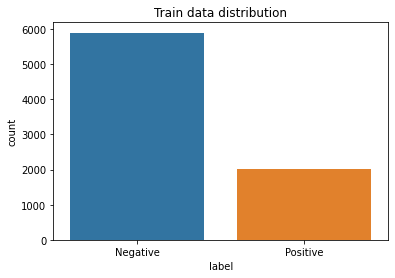

In [5]:
ax = sns.countplot(x="label", data=train_set)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)
ax.set_title('Train data distribution')

## Word tokenization and embedding

As we aim to use the dilstil BERT classifier as our pre-trained model after we fine tune for our goals, we must use the dilstilbert tokenizer to transform each word into a representation that the distil BERT was trained, thus avoiding any wrong tokenization. After this process each word will be represented as real valued vectors.

In [68]:
labels = train_set['label'].tolist()
tweets = train_set['tweet'].tolist()

#### Example of tweet

In [37]:
tweets[1]

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'

In [38]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/lasse/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /home/lasse/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/lasse/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e

In [39]:
inputs = tokenizer(tweets, padding='max_length', truncation=True)

In [11]:
class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
train_dataset = TwitterDataset(inputs, labels)

#### Tokenized tweet

In [75]:
train_dataset[1]['input_ids']

tensor([  101,  2633,  1037,  9099, 28689,  3372, 13773,  2553,  1034,  1034,
         4283,  2000,  2026,  4470,  1024,  1007,  1001,  8038,  2100,  1001,
         8412,  1001, 26726, 11610,  1001,  1055,  1001,  8412, 10288,  4842,
         7951,  1529,  8299,  1024,  1013,  1013, 16021, 23091,  1012,  4012,
         1013,  1052,  1013,  1061, 18150,  2629,  3501,  2278,  2575, 24703,
         1013,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

### Now lets take the pre-trained BERT and Fine tune for our sentiment classification task

In [13]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading: 100%|██████████| 256M/256M [00:18<00:00, 14.4MB/s] 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly init

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [14]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

In [15]:

trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset)
trainer.train()

***** Running training *****
  Num examples = 7920
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2970


Step,Training Loss
10,0.717900
20,0.706800
30,0.688900
40,0.619400
50,0.576000
60,0.527600
70,0.444000
80,0.384700
90,0.325600
100,0.383100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2970, training_loss=0.21447082948102694, metrics={'train_runtime': 409.095, 'train_samples_per_second': 58.079, 'train_steps_per_second': 7.26, 'total_flos': 3147425392066560.0, 'train_loss': 0.21447082948102694, 'epoch': 3.0})

## Testing the model
Now lets check our model output using a single tweet from the test set

In [78]:
def check_output(tweet, device, model):
    inputs = tokenizer(tweet, padding='max_length', truncation=True)
    ids = torch.tensor([inputs['input_ids']]).to(device)
    attn_mask = torch.tensor([inputs['attention_mask']]).to(device)


    with torch.no_grad():
        output = model(ids, attn_mask)

    output = np.argmax(output[0].cpu().numpy())

    return 'Negative' if output else 'Positive'

test_set  = pd.read_csv('test.csv')
tweet = test_set['tweet'].tolist()[0]

out = check_output(tweet, 'cuda', model)

I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks


In [67]:
print(f'Tweet "{tweet}" | Sentiment: {out}')

Tweet "I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks" | Sentiment: Negative


### Now lets creat a tweet of our own and check its sentiment with the model 

In [79]:
tweet = 'i love dogs'
out = check_output(tweet, 'cuda', model)
print(f'Tweet "{tweet}" | Sentiment: {out}')


i love dogs
Tweet "i love dogs" | Sentiment: Positive


In [83]:
tweet = 'i hate dogs'
out = check_output(tweet, 'cuda', model)
print(f'Tweet "{tweet}" | Sentiment: {out}')

i hate dogs
Tweet "i hate dogs" | Sentiment: Negative


In [84]:
model.save_pretrained('sentiment_twitter')

Configuration saved in sentiment_twitter/config.json
Model weights saved in sentiment_twitter/pytorch_model.bin
